<a href="https://colab.research.google.com/github/Mxhmovd/Mxhmovd/blob/main/LinearR_Housing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#imports
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, random_split
from torchvision.datasets.utils import download_url
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
#hyperparameters
batch_size = 64
lr = 5e-7

#CONSTANTS
ds_url = "https://raw.githubusercontent.com/selva86/datasets/master/BostonHousing.csv"
filename = "BostonHousing.csv"
column = "medv"
input_size = 13
output_size= 1

In [ ]:
#data download
download_url(ds_url, ".")
df = pd.read_csv(filename)
df.head()

  0%|          | 0/35735 [00:00<?, ?it/s]

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [ ]:
#convert from pandas df to numpy arrays
inputs = df.drop('medv', axis=1).values
targets = df[['medv']].values
inputs.shape, targets.shape

((506, 13), (506, 1))

In [ ]:
#convert to pytorch dataset
dataset = TensorDataset(torch.tensor(inputs, dtype=torch.float32), torch.tensor(targets, dtype=torch.float32))
train_ds, val_ds = random_split(dataset, [406, 100])

train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size*2)

In [ ]:
class HousingModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear = nn.Linear(input_size, output_size)

  def forward(self, xb):
    out = self.linear(xb)
    return out
  
  def training_step(self, batch):
    inputs, targets = batch
    out = self(inputs)  #generate preds
    loss = F.mse_loss(out, targets)   #calculate loss
    return loss

  def validation_step(self, batch):
    inputs, targets = batch
    out = self(inputs)
    loss = F.mse_loss(out, targets)   #compare
    return {"val_loss": loss.detach()}

  def validation_epoch_end(self, outputs):
    batch_losses = [x["val_loss"] for x in outputs]
    epoch_loss   = torch.stack(batch_losses).mean()   #combine losses
    return {'val_loss': epoch_loss.item()}

  def epoch_end(slef, epoch, result):
    print("Epoch [{}], val_loss: {:.4f}".format(epoch, result['val_loss']))

model = HousingModel()

In [ ]:
#training
def evaluate(model, val_loader):
  outputs = [model.validation_step(batch) for batch in val_loader]
  return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
  history = []
  optimizer = opt_func(model.parameters(), lr)
  for epoch in range(epochs):
      # Training Phase 
      for batch in train_loader:
          loss = model.training_step(batch)
          loss.backward()
          optimizer.step()
          optimizer.zero_grad()
      # Validation phase
      result = evaluate(model, val_loader)
      model.epoch_end(epoch, result)
      history.append(result)
  return history

In [ ]:
result = evaluate(model, val_loader)
result

{'val_loss': 4728.73681640625}

In [ ]:
history = fit(10, lr, model, train_loader, val_loader)

Epoch [0], val_loss: 341.3094
Epoch [1], val_loss: 261.9034
Epoch [2], val_loss: 212.0495
Epoch [3], val_loss: 171.9722
Epoch [4], val_loss: 148.7188
Epoch [5], val_loss: 125.0775
Epoch [6], val_loss: 109.6001
Epoch [7], val_loss: 98.6314
Epoch [8], val_loss: 90.9864
Epoch [9], val_loss: 86.4728


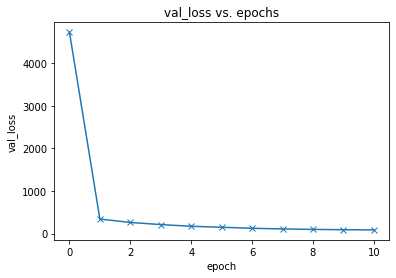

In [ ]:
losses = [r['val_loss'] for r in [result] + history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('val_loss')
plt.title('val_loss vs. epochs');

In [ ]:
def predict_single(x, model):
    xb = x.unsqueeze(0)
    return model(x).item()

In [ ]:
x, target = val_ds[10]
pred = predict_single(x, model)
print("Input: ", x)
print("Target: ", target.item())
print("Prediction:", pred)

Input:  tensor([  0.4479,   0.0000,   6.2000,   1.0000,   0.5070,   6.7260,  66.5000,
          3.6519,   8.0000, 307.0000,  17.4000, 360.2000,   8.0500])
Target:  29.0
Prediction: 19.830036163330078
